<a href="https://colab.research.google.com/github/TeriTeriLikeYumi/Yolov10-CustomDataset/blob/main/notebook/train_yolov10_object_detection_on_custom_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

## Install YOLOv10

**NOTE:** Currently, YOLOv10 does not have its own PyPI package. Therefore, we need to install the code from the source.

In [3]:
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**NOTE:** We will also install two additional packages: [`roboflow`](https://github.com/roboflow/roboflow-python) to download the dataset from [Roboflow Universe](https://universe.roboflow.com/), which we will use to train our model, and [`supervision`](https://github.com/roboflow/supervision), which we will use for visualizing the results.

In [4]:
!pip install -q supervision roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.6 MB/s eta 0:00:00


## Download pre-trained weights

**NOTE:** YOLOv10 provides weight files pre-trained on the COCO dataset in various sizes. Let's download them.

In [5]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!ls -lh {HOME}/weights

total 32M
-rw-r--r-- 1 root root 32M May 26 15:54 yolov10s.pt


## Download dataset from Roboflow Universe

In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

from google.colab import userdata
from roboflow import Roboflow

# SET UP  ROBOFLOW ACCOUNT TO GET API KEY DATASET

ROBOFLOW_API_KEY = "U8tJYgb1VcARmHwyBoOx" #@param {type: "string"}
rf = Roboflow(api_key=ROBOFLOW_API_KEY)
project = rf.workspace("fruits-dataset").project("fruit-dataset-dha1m")
version = project.version(1)
dataset = version.download("yolov9")

/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Fruit-Dataset-1 in yolov9:: 100%|██████████| 4012/4012 [00:01<00:00, 3681.46it/s]


**NOTE:**
Make sure the last 4 lines of the data.yaml file have the following format:

```
test: ../test/images
train: ../train/images
val: ../valid/images
```

If using a dataset from Roboflow Universe, run the command below. 👇🏻

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

## Custom Training

In [8]:
%cd {HOME}

!yolo task=detect mode=train epochs=10 batch=32 plots=True \
model={HOME}/weights/yolov10s.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.79 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10s.pt, data=/content/datasets/Fruit-Dataset-1/data.yaml, epochs=10, time=None, patience=100, batch=32, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes

In [9]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1724232702.e19032754325.2332.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


In [10]:
from IPython.display import Image
import cv2
import supervision as sv

/content


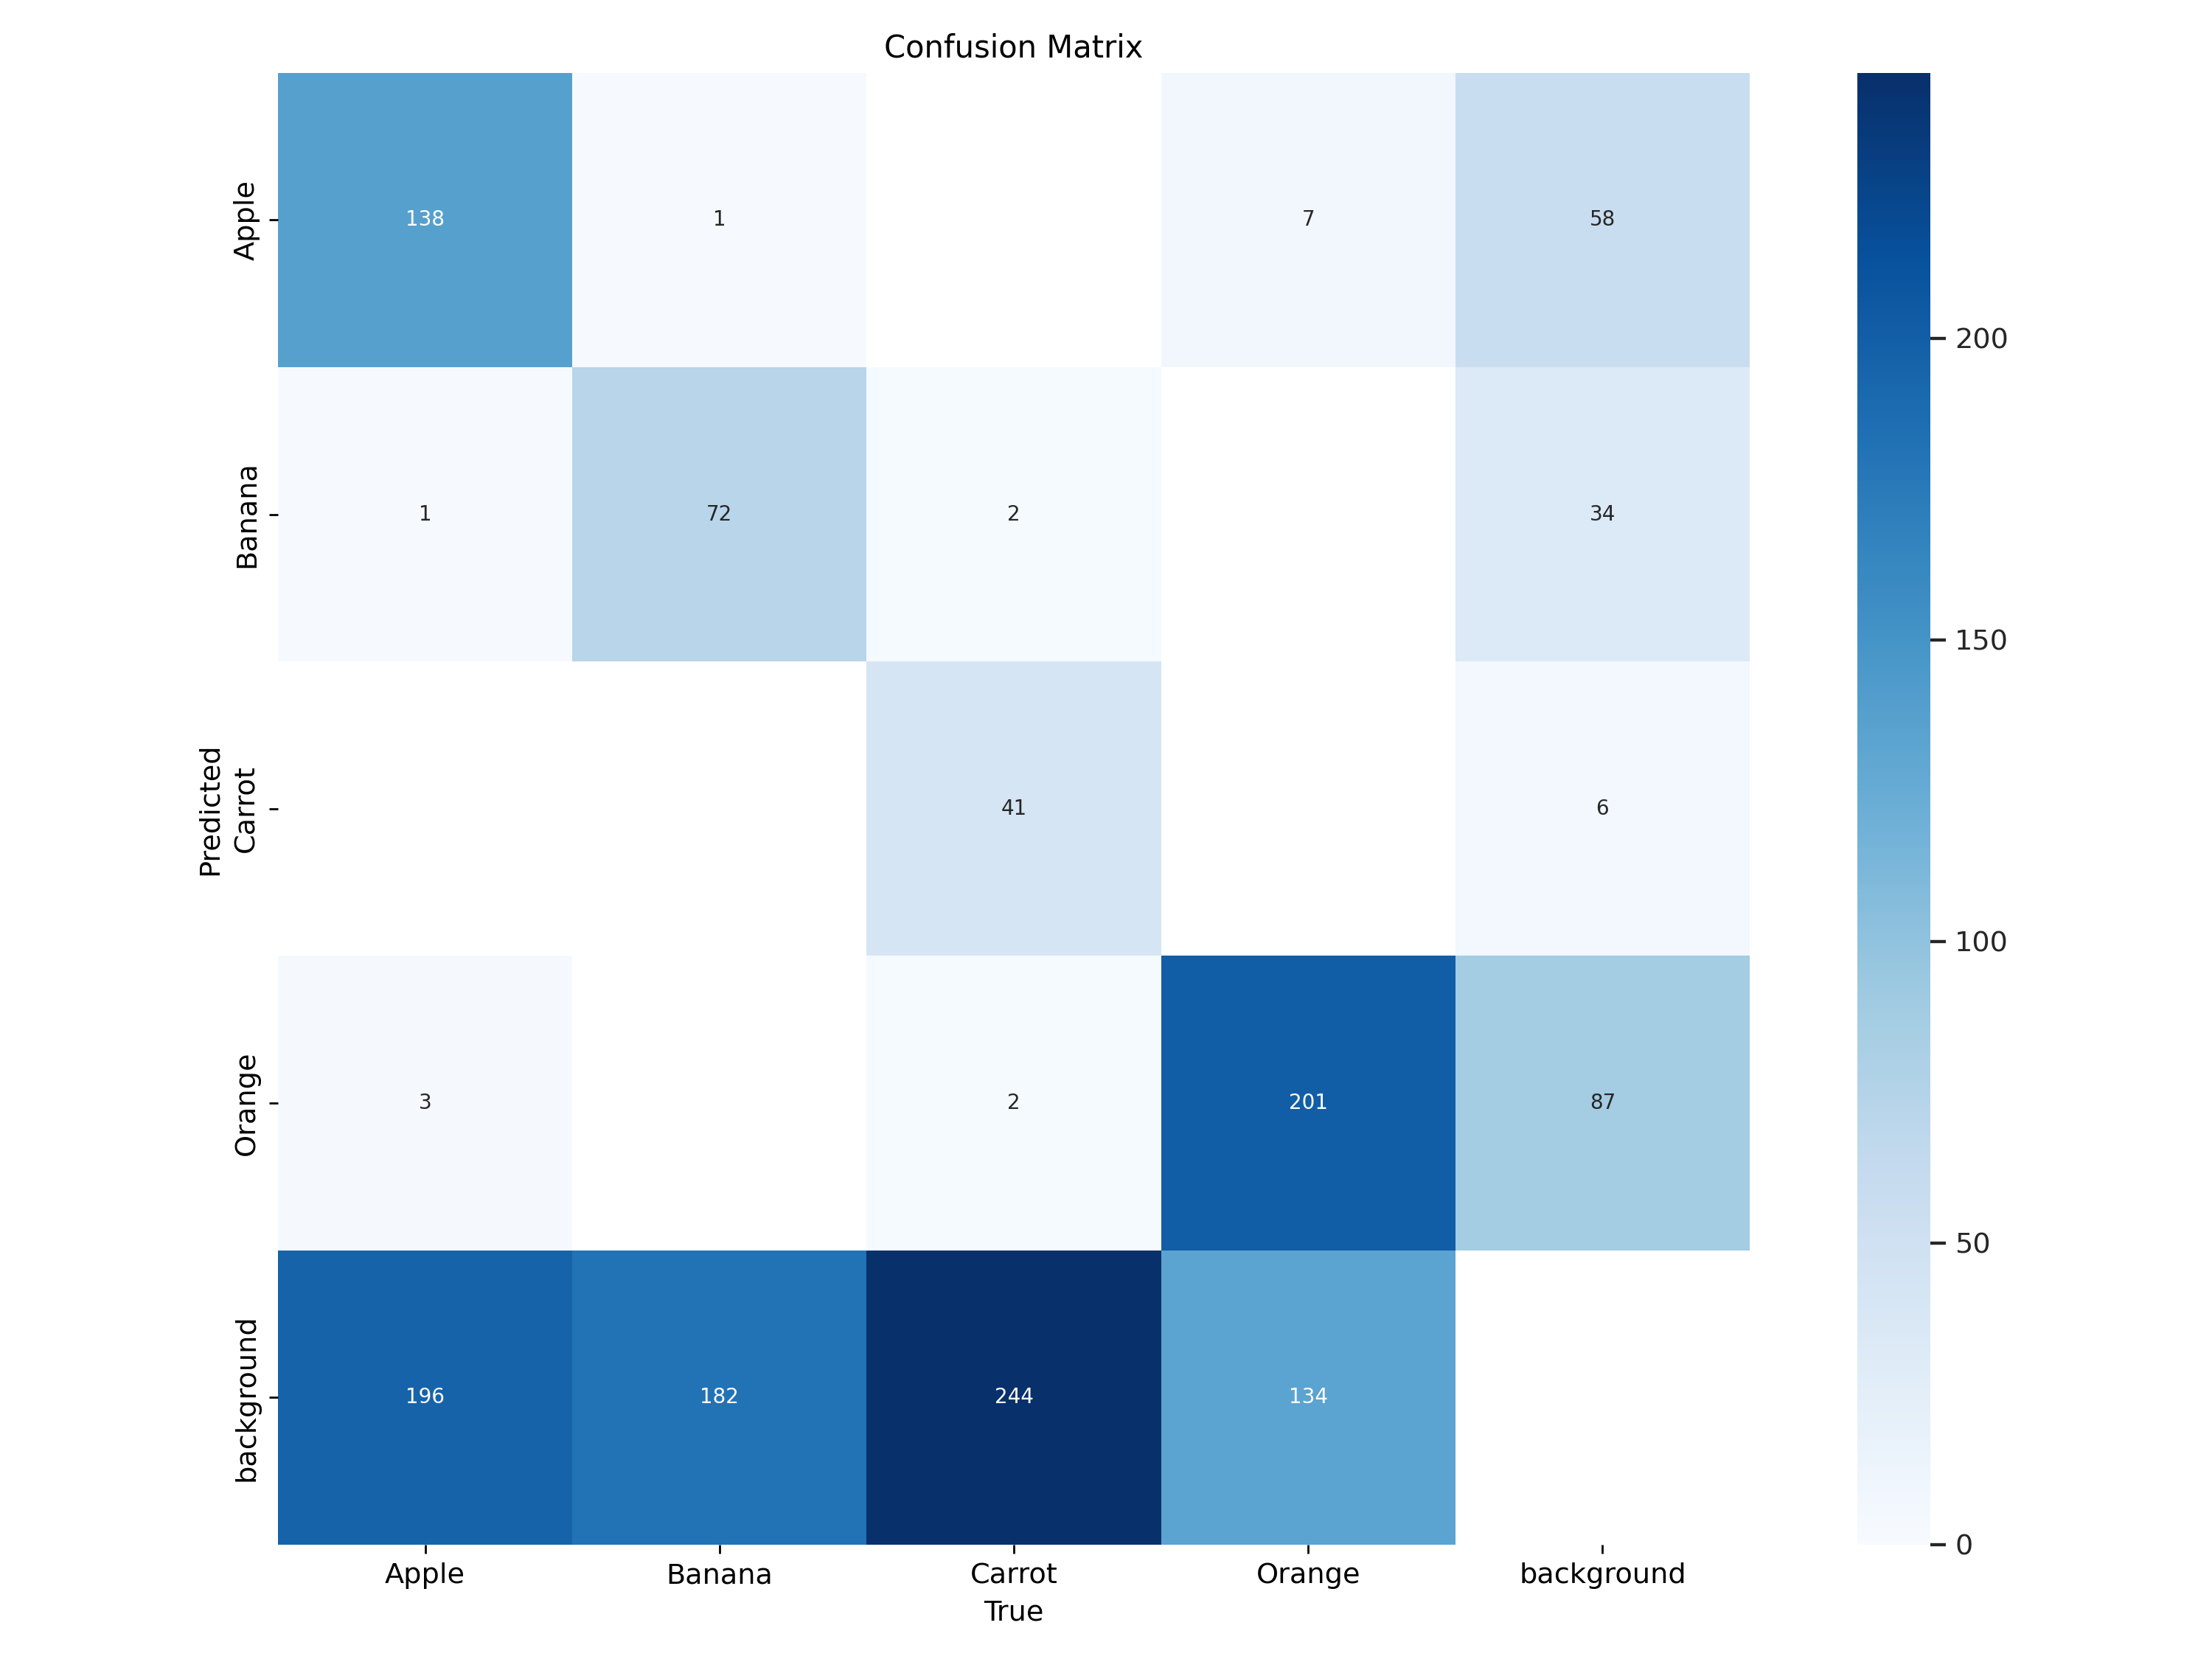

In [11]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


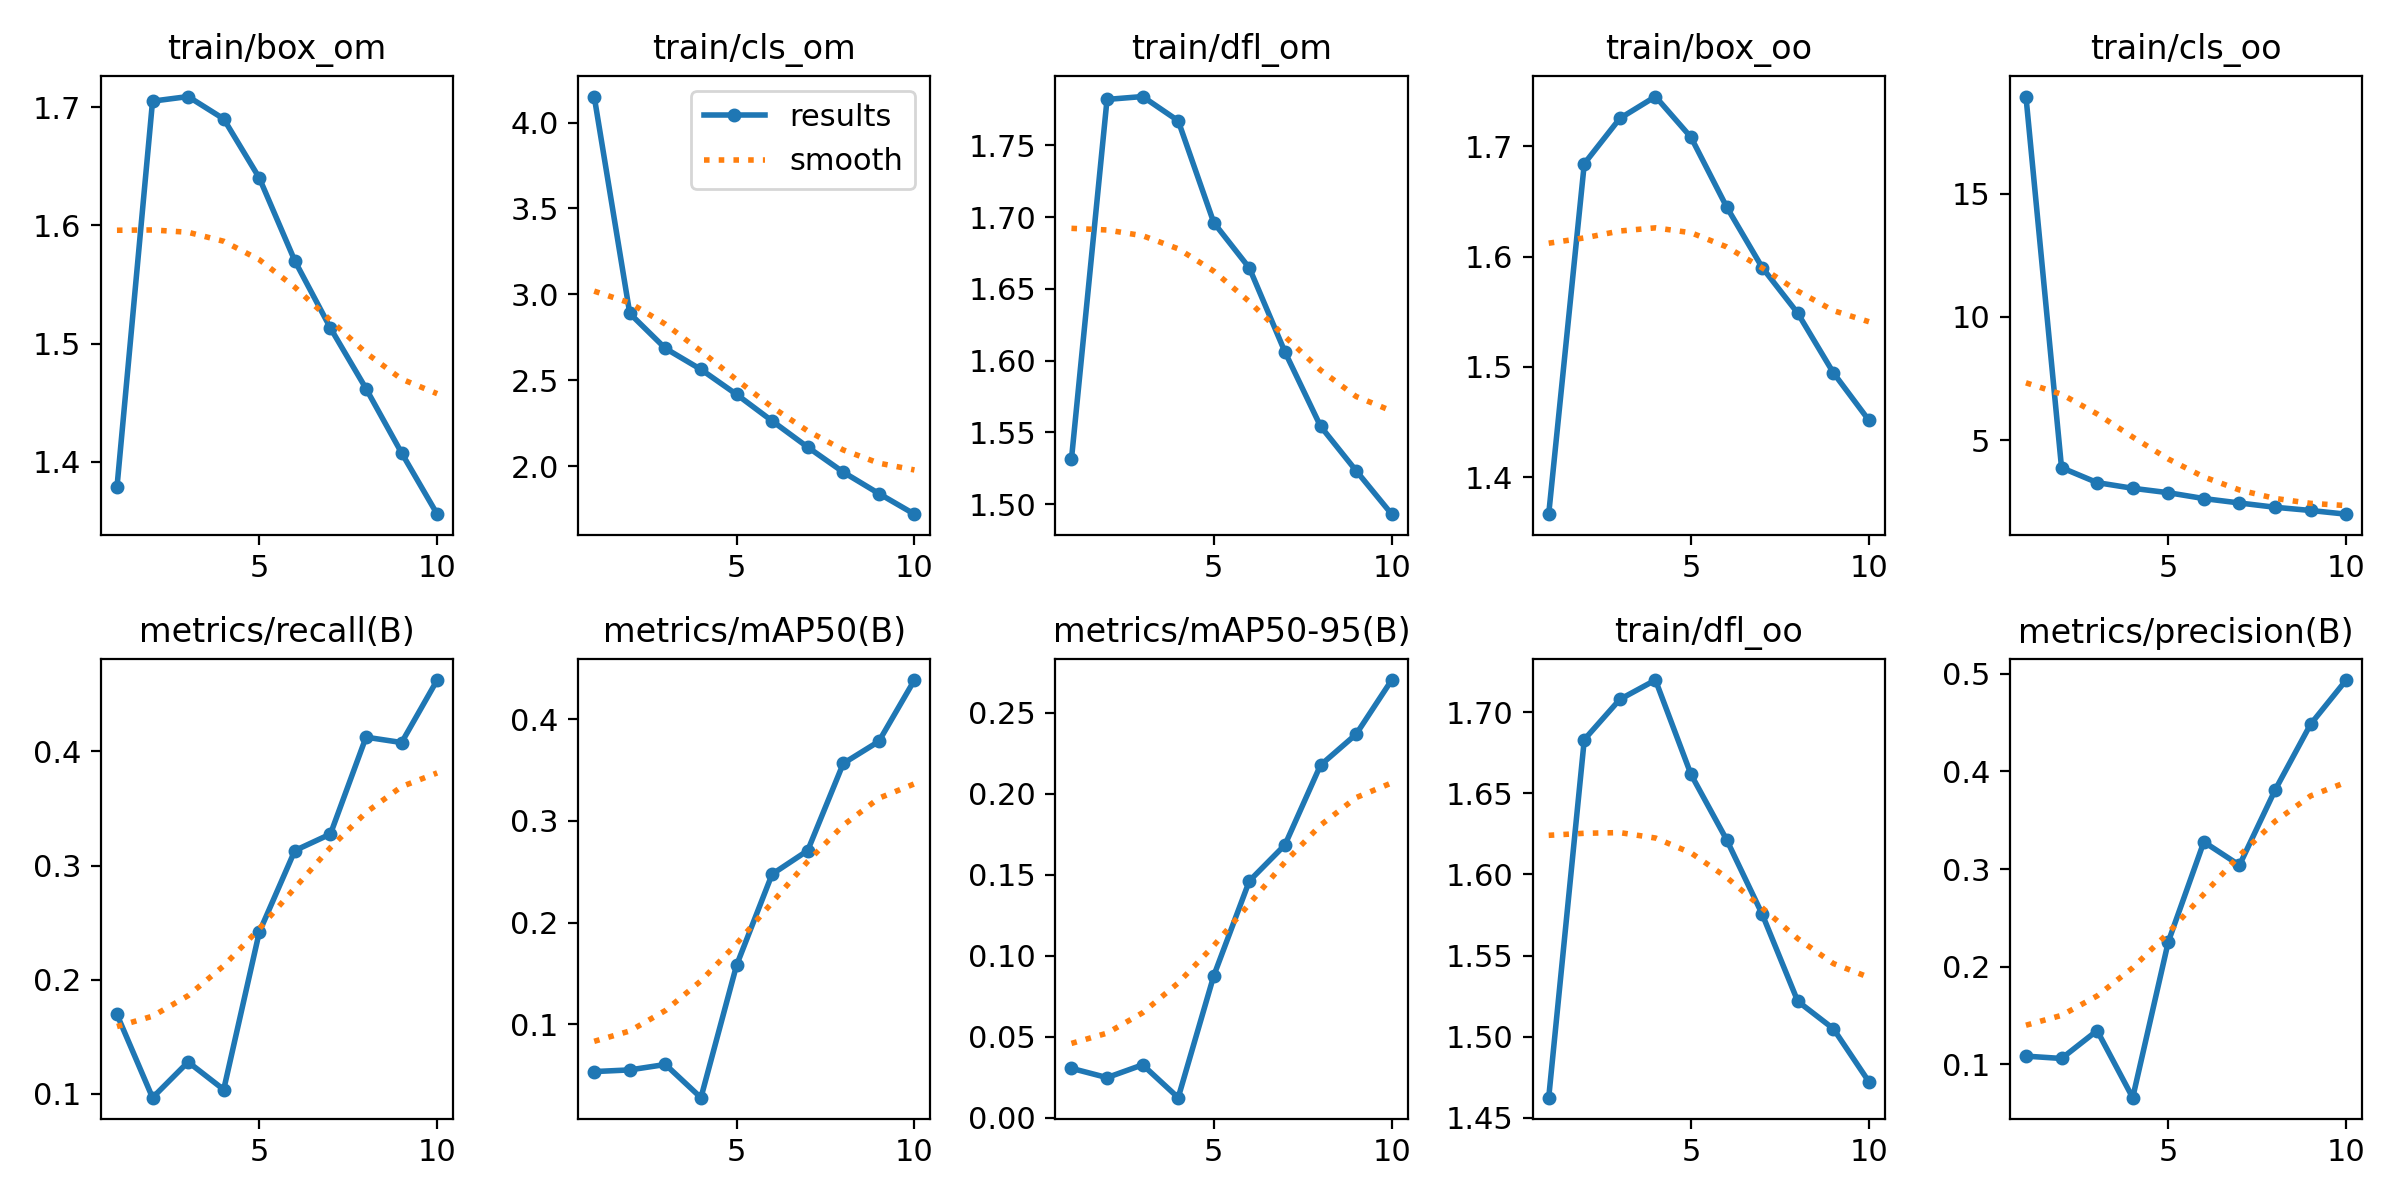

In [12]:
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

## Inference with Custom Model

**NOTE:** Let's start by loading our newly trained model.

In [13]:
from ultralytics import YOLOv10

model = YOLOv10(f'{HOME}/runs/detect/train/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

**NOTE:** Let's randomly select an image from our validation set and visualize the results.

SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.
SupervisionWarnings: images is deprecated: `DetectionDataset.images` property is deprecated and will be removed in `supervision-0.26.0`. Iterate with `for path, image, annotation in dataset:` instead.



0: 640x448 5 Apples, 75.7ms
Speed: 3.6ms preprocess, 75.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


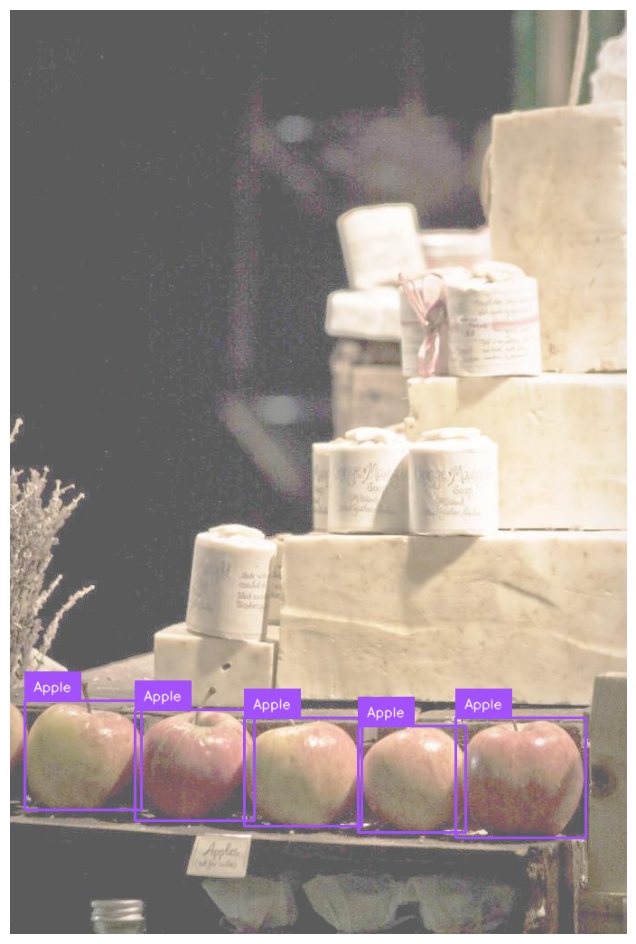

In [17]:
import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
!cp -r '/content/runs/detect/train' '/content/drive/MyDrive'